In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.covariance import LedoitWolf

# Data fetching
# Custom data fetcher to replace broken YahooDataProvider
# The qiskit-finance YahooDataProvider has compatibility issues with latest yfinance
import yfinance as yf

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Extract data

In [3]:
# Portfolio parameters
# Data parameters
START_DATE = datetime.now() - timedelta(days=365*2)  # 2 years of data
END_DATE = datetime.now()

# S&P 500 stocks (diversified sector selection)
TICKERS = [
    # Technology
    'NVDA',  # NVIDIA
    'MSFT',  # Microsoft
    'AAPL',  # Apple
    'AMZN',  # Amazon
    'META',  # Meta
    'AVGO',  # Broadcom
    'GOOGL', # Alphabet
    'TSLA',  # Tesla
    'BRK-B', # Berkshire Hathaway
    'WMT',   # Walmart
]


print(f"Configuration:")
print(f"  Tickers: {TICKERS}")
print(f"  Date range: {START_DATE.date()} to {END_DATE.date()}")

Configuration:
  Tickers: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'BRK-B', 'WMT']
  Date range: 2023-10-26 to 2025-10-25


In [4]:
def fetch_stock_data(tickers, start_date, end_date):
    """
    Fetch stock data and compute returns, covariance, and correlation.

    Args:
        tickers: List of ticker symbols
        start_date: Start date
        end_date: End date

    Returns:
        mean_returns, covariance_matrix, daily_returns, prices
    """
    print(f"Fetching data for {len(tickers)} stocks from Yahoo Finance...")

    # Download data
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False, progress=False)

    # Extract adjusted close prices
    if len(tickers) == 1:
        prices = data['Adj Close'].to_frame()
        prices.columns = tickers
    else:
        prices = data['Adj Close']

    # Drop any NaN values
    prices = prices.dropna()

    print(f"Downloaded {len(prices)} days of price data")

    # Calculate daily returns
    returns = prices.pct_change().dropna()

    # Calculate mean returns (daily)
    mean_returns = returns.mean().values

    # Calculate sample covariance matrix (daily)
    sample_covariance_matrix = returns.cov().values

    return mean_returns, sample_covariance_matrix, returns, prices

mean_returns, covariance_matrix, daily_returns, price_data = fetch_stock_data(
    TICKERS, START_DATE, END_DATE
)

print(f"\nData fetched successfully!")
print(f"Mean returns shape: {mean_returns.shape}")
print(f"Covariance matrix shape: {covariance_matrix.shape}")
print(f"Daily returns shape: {daily_returns.shape}")

Fetching data for 10 stocks from Yahoo Finance...
Downloaded 501 days of price data

Data fetched successfully!
Mean returns shape: (10,)
Covariance matrix shape: (10, 10)
Daily returns shape: (500, 10)


In [5]:
for i, ticker in enumerate(TICKERS):
    print(f"  {ticker}: {mean_returns[i]*252:.2%}")  # Annualized (252 trading days)

  NVDA: 27.29%
  MSFT: 36.41%
  AAPL: 87.99%
  AMZN: 20.59%
  META: 42.69%
  AVGO: 54.16%
  GOOGL: 26.75%
  TSLA: 89.97%
  BRK-B: 57.30%
  WMT: 37.69%


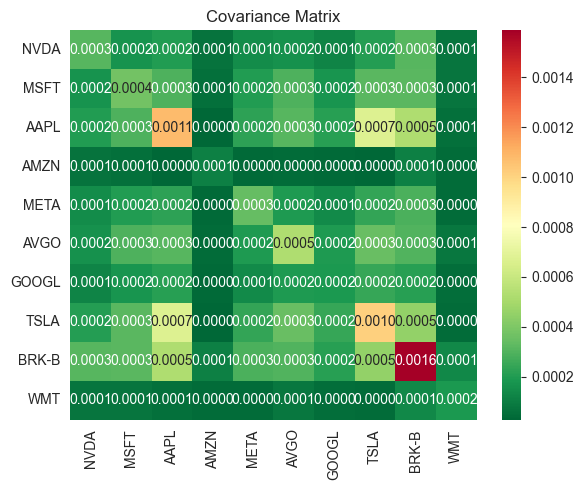

In [6]:
# Visualize covariance matrix - single plot version
plt.figure(figsize=(6, 5))

# Covariance matrix
sns.heatmap(covariance_matrix, annot=True, fmt='.4f', cmap='RdYlGn_r',
            xticklabels=TICKERS, yticklabels=TICKERS)
plt.title('Covariance Matrix')

plt.tight_layout()
plt.show()

In [7]:
covariance_matrix

array([[3.13036962e-04, 1.73503427e-04, 1.98669495e-04, 6.55081056e-05,
        1.48176984e-04, 1.62206777e-04, 1.23542953e-04, 2.06204385e-04,
        3.14351205e-04, 7.37174911e-05],
       [1.73503427e-04, 3.74633525e-04, 2.94147225e-04, 5.73926860e-05,
        1.99693833e-04, 2.95445424e-04, 1.76793245e-04, 3.17659818e-04,
        3.17285560e-04, 7.49841477e-05],
       [1.98669495e-04, 2.94147225e-04, 1.07784181e-03, 2.79928589e-05,
        2.28958060e-04, 3.11809861e-04, 2.11758512e-04, 6.71981706e-04,
        5.25907842e-04, 5.81402368e-05],
       [6.55081056e-05, 5.73926860e-05, 2.79928589e-05, 1.08926155e-04,
        3.53547691e-05, 4.56227198e-05, 3.77522676e-05, 3.27391768e-05,
        1.07905538e-04, 4.37790718e-05],
       [1.48176984e-04, 1.99693833e-04, 2.28958060e-04, 3.53547691e-05,
        3.44023576e-04, 1.92755721e-04, 1.38668822e-04, 2.41052047e-04,
        2.86480550e-04, 4.18916375e-05],
       [1.62206777e-04, 2.95445424e-04, 3.11809861e-04, 4.56227198e-05,
   

# Ledoit-Wolf Function

In [8]:
# Ledoit-Wolf Shrinkage
lw_estimator = LedoitWolf()
lw_estimator.fit(daily_returns)

shrunk_cov_matrix = lw_estimator.covariance_

print("Ledoit-Wolf Estimator")
print(f"Optimal shrinkage coefficient (delta*): {lw_estimator.shrinkage_:.6f}")
print(f"Shrunk covariance matrix shape: {shrunk_cov_matrix.shape}")

Ledoit-Wolf Estimator
Optimal shrinkage coefficient (delta*): 0.045532
Shrunk covariance matrix shape: (10, 10)


In [9]:
shrunk_cov_matrix

array([[3.24186357e-04, 1.65272339e-04, 1.89244517e-04, 6.24003689e-05,
        1.41147395e-04, 1.54511608e-04, 1.17682015e-04, 1.96421948e-04,
        2.99438230e-04, 7.02202973e-05],
       [1.65272339e-04, 3.82860750e-04, 2.80192737e-04, 5.46699489e-05,
        1.90220260e-04, 2.81429349e-04, 1.68406087e-04, 3.02589880e-04,
        3.02233378e-04, 7.14268630e-05],
       [1.89244517e-04, 2.80192737e-04, 1.05270849e-03, 2.66648640e-05,
        2.18096177e-04, 2.97017448e-04, 2.01712585e-04, 6.40102564e-04,
        5.00958516e-04, 5.53820355e-05],
       [6.24003689e-05, 5.46699489e-05, 2.66648640e-05, 1.29758667e-04,
        3.36775215e-05, 4.34583556e-05, 3.59612816e-05, 3.11860142e-05,
        1.02786446e-04, 4.17021712e-05],
       [1.41147395e-04, 1.90220260e-04, 2.18096177e-04, 3.36775215e-05,
        3.53702951e-04, 1.83611296e-04, 1.32090305e-04, 2.29616420e-04,
        2.72889773e-04, 3.99042777e-05],
       [1.54511608e-04, 2.81429349e-04, 2.97017448e-04, 4.34583556e-05,
   

# QUBO formulation

In [10]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

# ---------- Parámetros del problema ----------
B = 4                  # cardinalidad (nº de activos seleccionados)
LAMBDA = 5.0           # aversión al riesgo
P_LAYERS = 2           # profundidad QAOA
SHOTS = 8000           # tiros de muestreo
SEED = 7               # reproducibilidad
USE_EQUAL_WEIGHT = True

rng = np.random.default_rng(SEED)

# Datos desde PARTE 1
mu = mean_returns.copy()            # vector (n,)
Sigma = shrunk_cov_matrix.copy()    # matriz (n,n)
n = len(TICKERS)
assert 1 <= B <= n

# ---------- QUBO clásico ----------
# f(x) = x^T Q x + q^T x con |x|=B; pesos iguales: w = x/B
if USE_EQUAL_WEIGHT:
    Q = (LAMBDA / (B**2)) * Sigma
    q = -(1.0 / B) * mu
else:
    Q = LAMBDA * Sigma
    q = -mu
Q = 0.5 * (Q + Q.T)  # asegurar simetría

# ---------- QUBO -> Ising (Z) ----------
# x_i = (1 - Z_i)/2 ; x_i x_j = (1 - Z_i - Z_j + Z_iZ_j)/4
def qubo_to_ising(Q, q):
    J = np.zeros((n, n))
    h = np.zeros(n)
    const = 0.0
    for i in range(n):
        for j in range(i+1, n):
            Jij = Q[i, j] / 4.0
            J[i, j] = Jij
            h[i] += -Q[i, j] / 4.0
            h[j] += -Q[i, j] / 4.0
            const += Q[i, j] / 4.0
    for i in range(n):
        h[i] += -(Q[i, i] / 2.0) - (q[i] / 2.0)
        const += (Q[i, i] / 2.0) + (q[i] / 2.0)
    return J, h, const

J, h, const_shift = qubo_to_ising(Q, q)

# ---------- Estado inicial con |x|=B (ALEATORIO) ----------
init_idx = rng.choice(n, size=B, replace=False)   # <-- cambio solicitado
init_bits = np.zeros(n, dtype=int)
init_bits[init_idx] = 1

# ---------- Ansatz QAOA con mixer XY (anillo) ----------
def build_qaoa_xy(n, P, J, h, init_bits):
    qc = QuantumCircuit(n, name="QAOA_XY")
    for i, b in enumerate(init_bits):
        if b == 1:
            qc.x(i)

    gammas = [Parameter(f"γ_{k}") for k in range(P)]
    betas  = [Parameter(f"β_{k}") for k in range(P)]

    ring_pairs = [(i, (i+1) % n) for i in range(n)]  # conectividad anillo

    for k in range(P):
        γ = gammas[k]
        β = betas[k]
        # Coste: RZ(2γ h_i) + RZZ(2γ J_ij)
        for i in range(n):
            if abs(h[i]) > 1e-15:
                qc.rz(2.0 * γ * h[i], i)
        for i in range(n):
            for j in range(i+1, n):
                if abs(J[i, j]) > 1e-15:
                    qc.append(RZZGate(2.0 * γ * J[i, j]), [i, j])
        # Mixer XY (preserva cardinalidad)
        for (i, j) in ring_pairs:
            qc.append(RXXGate(2.0 * β), [i, j])
            qc.append(RYYGate(2.0 * β), [i, j])
    return qc, gammas + betas

ansatz, theta_params = build_qaoa_xy(n, P_LAYERS, J, h, init_bits)

# ---------- Utilidades ----------
def f_qubo(x):
    return float(x @ Q @ x + q @ x)

def bitstr_from_int(k, n):
    return np.array(list(np.binary_repr(k, width=n)), dtype=int)

def bitarray_from_qiskit_string(s):
    # Qiskit devuelve string little-endian (q_{n-1} ... q_0)
    return np.array(list(s[::-1]), dtype=int)

def bind_params(circ, mapping):
    """Compatibilidad Terra: primero assign_parameters, si no existiera, bind_parameters."""
    try:
        return circ.assign_parameters(mapping, inplace=False)
    except Exception:
        try:
            return circ.bind_parameters(mapping)
        except Exception as e:
            raise RuntimeError(f"No se pudieron asignar parámetros: {e}")

# Expectativa exacta vía statevector (diagonal en base computacional)
def expectation_statevector(theta):
    bind = {p: float(t) for p, t in zip(theta_params, theta)}
    circ_b = bind_params(ansatz, bind)
    sv = Statevector.from_instruction(circ_b)
    amps = sv.data
    exp = 0.0
    for idx, amp in enumerate(amps):
        p = (amp.conjugate() * amp).real
        if p < 1e-16:
            continue
        x = bitstr_from_int(idx, n)
        if x.sum() != B:  # robustez (el XY debería preservarlo)
            continue
        exp += p * f_qubo(x)
    return exp

# ---------- Optimización con traza de energía ----------
qaoa_trace = []

def objective_with_trace(th):
    val = expectation_statevector(th)
    qaoa_trace.append(val)
    return val

try:
    from scipy.optimize import minimize
    use_scipy = True
except Exception as e:
    print(f"[Aviso] SciPy no disponible ({e}). Se usará búsqueda aleatoria.")
    use_scipy = False

def random_theta():
    return np.concatenate([
        rng.uniform(0.0, 2.0*np.pi, size=P_LAYERS),  # gammas
        rng.uniform(0.0, 2.0*np.pi, size=P_LAYERS),  # betas
    ])

t0_opt = time.perf_counter()
if use_scipy:
    best_val, best_theta = np.inf, None
    for _ in range(5):  # multi-start ligero
        x0 = random_theta()
        res = minimize(objective_with_trace, x0, method="COBYLA",
                       options={"maxiter": 250, "rhobeg": 0.5})
        if res.fun < best_val:
            best_val, best_theta = res.fun, res.x
else:
    best_val, best_theta = np.inf, None
    for _ in range(100):
        th = random_theta()
        val = objective_with_trace(th)
        if val < best_val:
            best_val, best_theta = val, th
t1_opt = time.perf_counter()

print(f"\n[QAOA] Mejor expectativa estimada: {best_val:.6f}")
print(f"[QAOA] θ* = {best_theta}")

# ---------- Muestreo y selección ----------
meas_qc = bind_params(ansatz, {p: float(t) for p, t in zip(theta_params, best_theta)}).copy()
meas_qc.measure_all()

backend = AerSimulator()
tqc = transpile(meas_qc, backend, optimization_level=1, seed_transpiler=SEED)

t0_samp = time.perf_counter()
res = backend.run(tqc, shots=SHOTS, seed_simulator=SEED).result()
t1_samp = time.perf_counter()

counts = res.get_counts()

# Filtrar |x|=B y elegir mejor coste
cands = []
for s, c in counts.items():
    x = bitarray_from_qiskit_string(s)
    if x.sum() == B:
        cands.append((s, c, f_qubo(x)))

if not cands:
    raise RuntimeError("No se observaron bitstrings con cardinalidad B (muy raro con mixer XY).")

s_best, c_best, fx_best = min(cands, key=lambda t: t[2])
x_best = bitarray_from_qiskit_string(s_best)
sel_idx = np.where(x_best == 1)[0]
sel_tickers = [TICKERS[i] for i in sel_idx]

print("\n[Resultado QAOA-XY]")
print(f"Bitstring (little-endian): {s_best}  (freq {c_best}/{SHOTS})")
print(f"Seleccionados ({len(sel_idx)} = B): {sel_tickers}")
print(f"f(x*) = {fx_best:.6f}")

# Métricas (pesos iguales)
w = np.zeros(n)
w[sel_idx] = 1.0 / B
mu_day = float(mu @ w)
var_day = float(w @ Sigma @ w)
mu_ann = 252 * mu_day
std_ann = np.sqrt(252 * var_day)
print("\n[Métricas aprox.]")
print(f"Rentabilidad esperada anual ≈ {mu_ann:.2%}")
print(f"Volatilidad anual ≈ {std_ann:.2%}")


[QAOA] Mejor expectativa estimada: -0.000845
[QAOA] θ* = [2.63646092 6.05951275 0.52151578 5.42359629]

[Resultado QAOA-XY]
Bitstring (little-endian): 1010011000  (freq 1/8000)
Seleccionados (4 = B): ['AMZN', 'META', 'TSLA', 'WMT']
f(x*) = -0.001108

[Métricas aprox.]
Rentabilidad esperada anual ≈ 47.73%
Volatilidad anual ≈ 19.91%


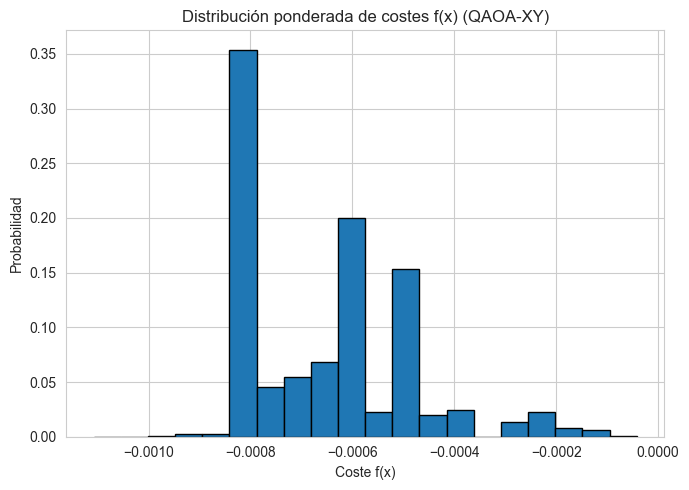

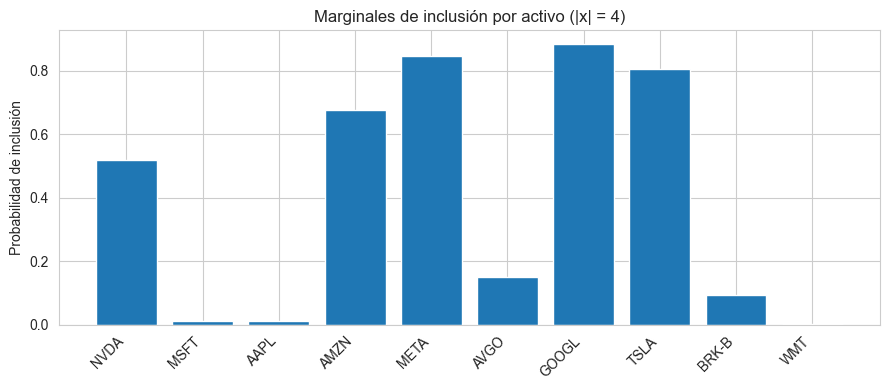

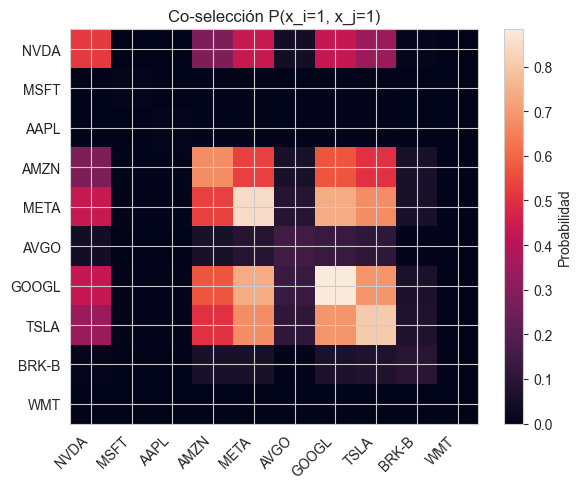

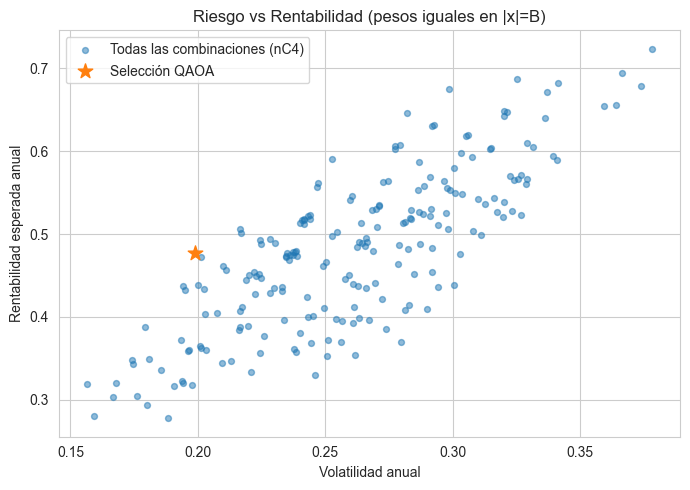

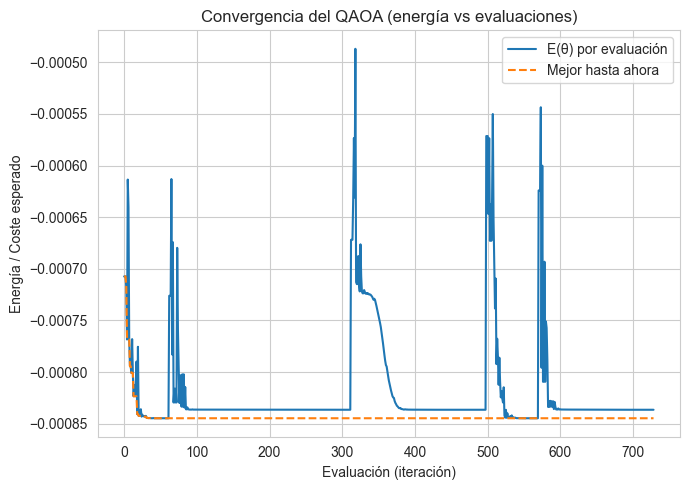


[Complejidad del circuito]
Qubits: 10, Capas p: 2, Parámetros: 4
Pre-transpile -> depth: 62, size: 154, ops: {'rzz': 90, 'rz': 20, 'rxx': 20, 'ryy': 20, 'x': 4}
Post-transpile -> depth: 63, size: 160, ops: {'rzz': 90, 'rxx': 20, 'ryy': 20, 'rz': 16, 'measure': 10, 'u3': 4, 'barrier': 1}
Tiempos -> Optimización: 9.60s | Muestreo: 0.04s


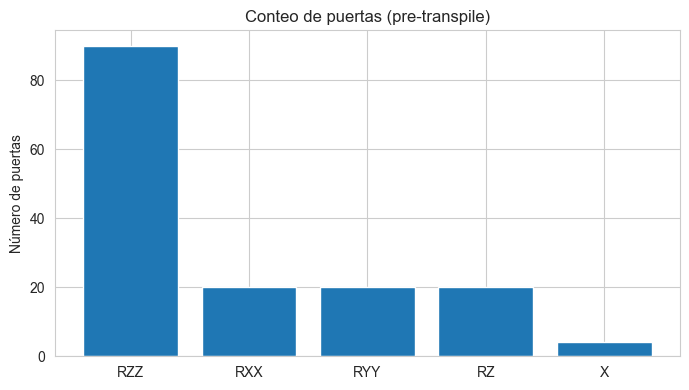


[Distribución de resultados |x|=B] Entropía: 2.3701 nats | Tamaño efectivo de muestra: 6.6


In [11]:
#VISUALIZATION BLOCK
#Construir DataFrame de muestras (solo |x|=B) ---
rows = []
total_shots = sum(counts.values())
for s, c in counts.items():
    x = bitarray_from_qiskit_string(s)
    if x.sum() != B:
        continue
    prob = c / total_shots
    cost = f_qubo(x)
    idx = np.where(x == 1)[0]
    tickers = [TICKERS[i] for i in idx]
    rows.append({
        "bitstring_qiskit_le": s,
        "shots": c,
        "prob": prob,
        "cost": cost,
        "indices": idx,
        "tickers": ", ".join(tickers)
    })
samples_df = pd.DataFrame(rows).sort_values(["prob", "cost"], ascending=[False, True]).reset_index(drop=True)

# --- 1) Histograma de costes ponderado por probabilidad ---
plt.figure(figsize=(7,5))
plt.hist(samples_df["cost"], bins=20, weights=samples_df["prob"], edgecolor="black")
plt.xlabel("Coste f(x)")
plt.ylabel("Probabilidad")
plt.title("Distribución ponderada de costes f(x) (QAOA-XY)")
plt.tight_layout()
plt.show()

# --- 2) Probabilidad marginal de inclusión por activo ---
p_incl = np.zeros(n)
for _, r in samples_df.iterrows():
    idx = np.array(r["indices"], dtype=int).reshape(-1)
    x = np.zeros(n)
    x[idx] = 1
    p_incl += r["prob"] * x

plt.figure(figsize=(9,4))
plt.bar(TICKERS, p_incl)
plt.ylabel("Probabilidad de inclusión")
plt.title(f"Marginales de inclusión por activo (|x| = {B})")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- 3) Heatmap de co-selección P(x_i=1, x_j=1) ---
P_ij = np.zeros((n, n))
for _, r in samples_df.iterrows():
    idx = np.array(r["indices"], dtype=int).reshape(-1)
    for i in idx:
        for j in idx:
            P_ij[i, j] += r["prob"]

plt.figure(figsize=(6,5))
plt.imshow(P_ij, aspect='auto')
plt.xticks(range(n), TICKERS, rotation=45, ha="right")
plt.yticks(range(n), TICKERS)
plt.title("Co-selección P(x_i=1, x_j=1)")
plt.colorbar(label="Probabilidad")
plt.tight_layout()
plt.show()

# --- 4) Riesgo-Rentabilidad: todas las combinaciones C(n,B) vs selección QAOA ---
from itertools import combinations
def metrics_for_indices(sel_idx):
    idx = np.array(sel_idx, dtype=int).reshape(-1)
    w = np.zeros(n)
    w[idx] = 1.0 / B
    mu_day = float(mu @ w)
    var_day = float(w @ Sigma @ w)
    mu_ann = 252 * mu_day
    std_ann = np.sqrt(252 * var_day)
    return mu_ann, std_ann

all_mu, all_std = [], []
for comb in combinations(range(n), B):  # nCk (para n=10, B=4 => 210)
    m, s = metrics_for_indices(comb)
    all_mu.append(m)
    all_std.append(s)

qaoa_mu, qaoa_std = metrics_for_indices(sel_idx)

plt.figure(figsize=(7,5))
plt.scatter(all_std, all_mu, s=18, alpha=0.5, label=f"Todas las combinaciones (nC{B})")
plt.scatter([qaoa_std], [qaoa_mu], s=120, marker="*", label="Selección QAOA", zorder=3)
plt.xlabel("Volatilidad anual")
plt.ylabel("Rentabilidad esperada anual")
plt.title("Riesgo vs Rentabilidad (pesos iguales en |x|=B)")
plt.legend()
plt.tight_layout()
plt.show()

# --- 5) Convergencia del QAOA: energía vs evaluaciones ---
if len(qaoa_trace) > 0:
    y = np.array(qaoa_trace, dtype=float)
    best_so_far = np.minimum.accumulate(y)
    plt.figure(figsize=(7,5))
    plt.plot(y, label="E(θ) por evaluación")
    plt.plot(best_so_far, linestyle="--", label="Mejor hasta ahora")
    plt.xlabel("Evaluación (iteración)")
    plt.ylabel("Energía / Coste esperado")
    plt.title("Convergencia del QAOA (energía vs evaluaciones)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No hay traza de energía registrada.")

# --- 6) Complejidad del circuito: tamaño, profundidad, puertas ---
bound_circ = bind_params(ansatz, {p: float(t) for p, t in zip(theta_params, best_theta)})
pre_depth = bound_circ.depth()
pre_size  = bound_circ.size()
pre_ops   = bound_circ.count_ops()

tqc = transpile(bound_circ.measure_all(inplace=False) or bound_circ, backend)  # simple pass
post_depth = tqc.depth()
post_size  = tqc.size()
post_ops   = tqc.count_ops()

print("\n[Complejidad del circuito]")
print(f"Qubits: {n}, Capas p: {P_LAYERS}, Parámetros: {2*P_LAYERS}")
print(f"Pre-transpile -> depth: {pre_depth}, size: {pre_size}, ops: {dict(pre_ops)}")
print(f"Post-transpile -> depth: {post_depth}, size: {post_size}, ops: {dict(post_ops)}")
print(f"Tiempos -> Optimización: {(t1_opt - t0_opt):.2f}s | Muestreo: {(t1_samp - t0_samp):.2f}s")

labels, vals = [], []
for k in ["rzz", "rxx", "ryy", "rz", "x"]:
    if k in pre_ops:
        labels.append(k.upper()); vals.append(int(pre_ops[k]))
if labels:
    plt.figure(figsize=(7,4))
    plt.bar(labels, vals)
    plt.title("Conteo de puertas (pre-transpile)")
    plt.ylabel("Número de puertas")
    plt.tight_layout()
    plt.show()

# --- 7) Medidas de distribución ---
probs = samples_df["prob"].values
eps = 1e-16
entropy = -np.sum(np.where(probs > 0, probs * np.log(probs + eps), 0.0))
ess = 1.0 / np.sum((probs + eps)**2)
print(f"\n[Distribución de resultados |x|=B] Entropía: {entropy:.4f} nats | Tamaño efectivo de muestra: {ess:.1f}")
